In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import brier_score_loss

In [9]:
df = pd.read_csv('team_data_rolling_5yr.csv')
#df = pd.read_csv('team_data_rolling_10yr.csv')
df['GAME_DATE_home'] = pd.to_datetime(df['GAME_DATE_home'])
#df = df.loc[df['GAME_DATE_home'] > '2015-01-01']

In [10]:
df.columns

Index(['TEAM_home', 'TEAM_away', 'MATCHUP_home', 'MATCHUP_outcome',
       'GAME_DATE_home', 'W/L_binary_5_home', 'MIN_rolling_5_home',
       'PTS_rolling_5_home', 'FGM_rolling_5_home', 'FGA_rolling_5_home',
       ...
       'PYTHAG_rolling_5_away_sq', 'PYTHAG_rolling_5_away_sqrt',
       'FTDIFF_rolling_5_away_sq', 'FTDIFF_rolling_5_away_sqrt',
       'AST/TO_rolling_5_away_sq', 'AST/TO_rolling_5_away_sqrt',
       'AST/FGM_rolling_5_away_sq', 'AST/FGM_rolling_5_away_sqrt',
       'TOV%_rolling_5_away_sq', 'TOV%_rolling_5_away_sqrt'],
      dtype='object', length=211)

In [11]:
window='5'
X = df[[f'W/L_binary_{window}_home', f'W/L_binary_{window}_away', f'PTS_rolling_{window}_home', f'PTS_rolling_{window}_away']]
y = df['MATCHUP_outcome']
Xbig = df.drop(columns=['TEAM_home', 'TEAM_away', 'MATCHUP_home', 
                'MATCHUP_outcome', 'GAME_DATE_home'])

Xbig_train, Xbig_test, y_train, y_test = train_test_split(Xbig, y)

mod = LogisticRegression().fit(X, y)
mod.score(X, y)

0.6250961823024563

In [32]:
xgb = XGBClassifier().fit(Xbig_train, y_train)
print(xgb.score(Xbig_train, y_train))
print(xgb.score(Xbig_test, y_test))

C:\Users\jacob\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:38:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
1.0
1.0


In [13]:
nn = MLPClassifier((50, 50, 50, 50)).fit(Xbig_train, y_train)

print(nn.score(Xbig_train, y_train))
print(nn.score(Xbig_test, y_test))

0.6470681082787467
0.6387310606060606


In [35]:
print('nnet brier score')
print(brier_score_loss(y_test, np.max(nn.predict_proba(Xbig_test), axis=1)))
print('xgb brier score')
print(brier_score_loss(y_test, np.max(xgb.predict_proba(Xbig_test), axis=1)))

nnet brier score
0.31356390662582995
xgb brier score
0.5874506843961691


In [73]:
#obtain data to make brier score chart
briers, sizes = [0 for i in range(10)], [0 for i in range(10)]
probs = nn.predict_proba(Xbig_test)[:, 0]
trues = y_test.values
for i in range(len(preds)):
    if probs[i] < 0.1:
        j = 0
    elif probs[i] < 0.2:
        j = 1
    elif probs[i] < 0.3:
        j = 2
    elif probs[i] < 0.4:
        j = 3
    elif probs[i] < 0.5:
        j = 4
    elif probs[i] < 0.6:
        j = 5
    elif probs[i] < 0.7:
        j = 6
    elif probs[i] < 0.8:
        j = 7
    elif probs[i] < 0.9:
        j = 8
    else:
        j = 9
    
    sizes[j] += 1
    if probs[i] < 0.5 and trues[i] == 0:
        briers[j] += 1
    elif probs[i] >= 0.5 and trues[i] == 1:
        briers[j] += 1
    
print(briers, sizes)
briers = [briers[i]/max(1, sizes[i]) for i in range(len(briers))]
xs = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

[0, 0, 0, 0, 339, 563, 452, 160, 12, 0] [0, 0, 0, 0, 894, 1174, 1378, 679, 98, 1]


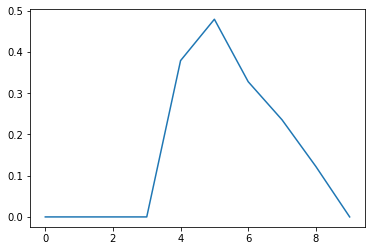

In [74]:
plt.plot(xs, briers)

Predictive Analytics for College Basketball: Using Logistic Regression for Determining the Outcome of a Game


Bryce Brown

In [7]:
#find top 20 features
X_dimred = SelectKBest(k=40).fit_transform(Xbig, y)
print(X_dimred.shape)
nlog = LogisticRegression().fit(X_dimred, y)
print(nlog.score(X_dimred, y))

nn = MLPClassifier((50, 50, 50, 50)).fit(X_dimred, y)
nn.score(X_dimred, y)

(8138, 40)
0.6338166625706562


C:\Users\jacob\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\jacob\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.45981813713443104